In [20]:
import numpy as np
import segyio
import matplotlib.pylab as plt
from examples.seismic import plot_shotrecord
%matplotlib inline
from examples.seismic import plot_velocity, plot_perturbation
from scipy import ndimage
from examples.seismic import Model
names = locals()

shape = (201, 101)   # Number of grid point (nx, nz)
spacing = (5, 5)  # Grid spacing in m.
origin = (0., 0.)  # What is the location of the top left corner.

v = np.ones(shape, dtype = np.float32)*2.0
'''
for i in range(shape[0]):
    v[i, :20] = 1.5
    v[i, 20:80] = 1.7
    v[i, 80:] = 1.9
'''

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,mytime=0.3,
                      space_order=4)

nshots = 51  # Need good covergae in shots, one every two grid points
nreceivers = 204  # One recevier every grid point
fwi_iterations=5 #number of outer FWI iterations
t0 = 0.
tn = 600.  # Simulation last 3.5 second (600 ms)
f0 = 0.015  # Source peak frequency is 25Hz (0.015 kHz)

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s


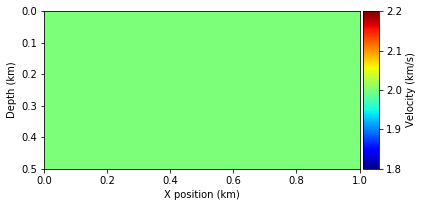

In [21]:
# Plot the true and initial model and the perturbation between them
plot_velocity(model)

In [22]:
geo = np.load('/home1/wangrongqian/hw/project_data/common.npy', allow_pickle=True).item()
for i in range(nshots):
    names['data' + str(i)] = np.load('/home1/wangrongqian/hw/project_data/project2_data_shot_'+str(i)+'.npy')

In [23]:
geo.keys()

dict_keys(['time_values', 'source', 'src_coordinates', 'rec_coordinates'])

In [24]:
data1.shape

(2001, 204)

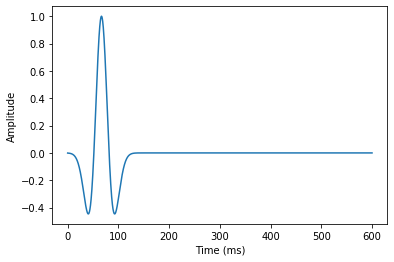

In [25]:
from examples.seismic import AcquisitionGeometry

# First, position source centrally in all dimensions, then set depth
src_coordinates = geo['src_coordinates']

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = geo['rec_coordinates']

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

In [26]:
src_coordinates[:, 1] = 500 - src_coordinates[:, 1]

In [27]:
rec_coordinates[:, 1] = 500 - rec_coordinates[:, 1]

In [28]:
# Define rtm operator for imaging
from devito import TimeFunction, Operator, Eq, solve
from examples.seismic import PointSource

def ImagingOperator(model, image):
    objective=0
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4,
                     save=geometry.nt)
    
    # Define the wave equation, but with a negated damping term
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T

    # Use `solve` to rearrange the equation into a stencil expression
    stencil = Eq(v.backward, solve(eqn, v.backward))
    
    # Define residual injection at the location of the forward receivers
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)
    
    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - u * v)
    return Operator([stencil] + res_term + [image_update],
                    subs=model.spacing_map)

In [29]:
from examples.seismic.acoustic import AcousticWaveSolver
solver = AcousticWaveSolver(model, geometry, space_order=4)
from examples.seismic import plot_shotrecord

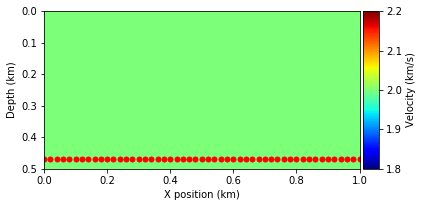

In [30]:
# Prepare the varying source locations
source_locations = src_coordinates

plot_velocity(model, source=source_locations)

In [37]:
# Run imaging loop over shots
from devito import Function

# Create image symbol and instantiate the previously defined imaging operator
image = Function(name='image', grid=model.grid)
op_imaging = ImagingOperator(model, image)
solver = AcousticWaveSolver(model, geometry, space_order=4)
objective=0
for i in range(nshots):
    print('Imaging source %d out of %d' % (i+1, nshots))
    
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]

    # Generate synthetic data from true model
    #true_d, _, _ = solver.forward(vp=model.vp)
    
    # Compute smooth data and full forward wavefield u0
    smooth_d, u0, _ = solver.forward(vp=model.vp, save=True)
    dat = smooth_d.data
    
    # Compute gradient from the data residual  
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)
    residual = dat - names['data' + str(i)]
    residual = np.float32(residual)
    op_imaging(u=u0, v=v, vp=model.vp, dt=1., 
               residual=residual)

Imaging source 1 out of 51


Operator `Forward` run in 0.25 s
Operator `Kernel` run in 0.19 s


Imaging source 2 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 3 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.19 s


Imaging source 4 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 5 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.19 s


Imaging source 6 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.21 s


Imaging source 7 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.19 s


Imaging source 8 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 9 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.22 s


Imaging source 10 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.21 s


Imaging source 11 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.20 s


Imaging source 12 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 13 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.21 s


Imaging source 14 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.21 s


Imaging source 15 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.21 s


Imaging source 16 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.20 s


Imaging source 17 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 18 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.21 s


Imaging source 19 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.21 s


Imaging source 20 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.21 s


Imaging source 21 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.21 s


Imaging source 22 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.21 s


Imaging source 23 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 24 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 25 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 26 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 27 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.20 s


Imaging source 28 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 29 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.21 s


Imaging source 30 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 31 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 32 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.21 s


Imaging source 33 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.21 s


Imaging source 34 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 35 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 36 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 37 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 38 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 39 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 40 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 41 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 42 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.19 s


Imaging source 43 out of 51


Operator `Forward` run in 0.16 s
Operator `Kernel` run in 0.20 s


Imaging source 44 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 45 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 46 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.19 s


Imaging source 47 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.19 s


Imaging source 48 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


Imaging source 49 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.19 s


Imaging source 50 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.19 s


Imaging source 51 out of 51


Operator `Forward` run in 0.15 s
Operator `Kernel` run in 0.20 s


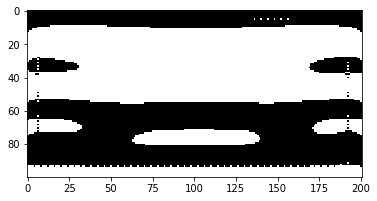

In [40]:
from examples.seismic import plot_image

# Plot the inverted image
data0 = image.data[20:-20,20:-20]
plt.imshow(np.diff(data0, axis=1).T,vmin=-1,vmax=10,cmap='gray')
plt.savefig('rtm4sr')
#plot_image(image.data)

In [ ]:
# Define bounding box constraints on the solution.
def apply_box_constraint(vp):
    # Maximum possible 'realistic' velocity is 3.5 km/sec
    # Minimum possible 'realistic' velocity is 2 km/sec
    return np.clip(vp, 2.0, 3.5)

In [ ]:
#NBVAL_SKIP

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model.vp)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / np.abs(direction).max()
    
    # Update the model estimate and enforce minimum/maximum values
    model.vp = apply_box_constraint(model.vp.data - alpha * direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))